Setup

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import torch
from torchvision import datasets, transforms
from torchvision.transforms import transforms
import torch.optim as optim
import torch.nn as nn
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.style.use('seaborn')
from tqdm import tqdm
from torch.distributions.multivariate_normal import MultivariateNormal
from src.get_data import *
from src.models import *
from src.utils import *
from src.nd import *
from src.visualize import *
from datetime import datetime
print(torch.version.cuda)
print(torch.__version__)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

12.1
2.2.2
cuda:0


C:\Users\yanch\AppData\Local\Temp\ipykernel_5296\571195691.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Setting hyperparameters

In [2]:
# vary these hyparams for different models and datasets
nonlin = 'Tanh' # 'Tanh' to replicate Fig.7

dataset = 'mnist'; dimension = 784 # set to 'mnist' to replicate Fig.7

base_class = [4]; test_class = [5] # set to [4] and [5] to replicate Fig.7, can be set to other classes, too

n_layers = 2 # adjust the number of hidden layers; 2 for hPCN
# the topmost layer go first in below arguments
hidden_sizes = [200, 400] # adjust the number of neurons in each hidden layer
kernel_sizes = [0,9] # adjust the size of receptive fields in each hidden layer; 0 means fully connected; 9 means connected to a 9x9 batch of neurons in the layer below
strides = [0,1] # adjust the stride of the receptive fields in each hidden layer
padding = 0 # typically not needed
paddings = [padding] * n_layers

# in the paper we the sparsity constraint we imposed is hardcoded, i.e., w_sparsity_penalty = 0. 
# As an alternative implementation of sparsity, can set w_sparsity_penalty to a positive value to add a l1 penalty to the weights during optimization
w_sparsity_penalty = 0 

# vary the number of patterns shown to the model to memorize
sample_sizes = [100] # set to [100] to replicate Fig.7

num_seeds = 1 # The number of seeds for the each sample size; set to 16 for the paper, but set to 1 here to save training time
seeds = range(num_seeds)

learning_lr = 8e-5 # learning rate of PCN; set to 8e-5 to replicate Fig.7
li = 4000 # number of learning iterations; set to 4000 to replicate Fig.7
learning_iters = np.ones_like(sample_sizes) * li

# initialize the arrays to store the results for different types of novelty detection, illustrated in Fig.6 and Fig.7B
separability_12 = np.zeros(shape=(len(seeds), n_layers+1)) # sensory (pixel) novelty
separability_23 = np.zeros(shape=(len(seeds), n_layers+1)) # semantic (digit for mnist) novelty


More setup given the hyperparameters (not necessary to understand code & results)

In [3]:
model_type = 'convolutional' # this refers the local connectivity we added in the hPCN model in the paper, the model isn't actually a CNN. 

PCN_retained = sample_sizes.copy()
PCN_accuracy = np.zeros(shape=(len(sample_sizes), len(seeds)))
PCN_error_probs = np.zeros(shape=(len(sample_sizes), len(seeds)))
batch_sizes = [sample_size // 2 for sample_size in sample_sizes]

# correlation between input neurons
b = 0
# Construct the covariance matrix
cov = np.ones((dimension, dimension)) * b
np.fill_diagonal(cov, 1)
# Generate the Cholesky decomposition of the covariance matrix
L = np.linalg.cholesky(cov)

inference_iters = 200
inference_lr = 0.1
lamb = 0

continuity = 'con' # 'con' or 'dis' for gaussian dataset
corruption = 'cover' # 'cover' or 'noise'

# controls the size of bins in energy distribution histograms
multiplyer = 0.4

if dataset == 'mnist':
    image_size = 28
elif dataset == 'cifar10':
    image_size = 32

current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
if dataset == 'gaussian':
    result_path = os.path.join('./results/', f'{current_time}_{model_type}_{dataset}_patterns_with_{dimension}_neurons_with_b = {b}')
else:
    result_path = os.path.join('./results/', f'{current_time}_{model_type}_{dataset}_hidden_sizes={hidden_sizes}_kernel_sizes={kernel_sizes}_strides={strides}_learning_lr={learning_lr}')
if not os.path.exists(result_path):
    os.makedirs(result_path)

all_mses = np.zeros((len(sample_sizes), len(seeds)))

Main training loop

In [4]:
for k in range(len(sample_sizes)):
    sample_size, batch_size, learning_iter = sample_sizes[k], batch_sizes[k], learning_iters[k]
    for ind, seed in enumerate(seeds):
        # The following chunk of code sets up the data for the experiment, including spliting data into training and testing sets
        print(f'sample size {sample_size}, seed {seed}')
        sample_size_test = sample_size
        X_data = np.zeros(shape=(sample_size, dimension))
        X_test_data = np.zeros(shape=(sample_size, dimension))
        if dataset == 'cifar10':
            (X, _), (X_test, _) = get_cifar10('./data', 
                                                sample_size=sample_size, 
                                                sample_size_test=sample_size,
                                                batch_size=batch_size, 
                                                seed=seed, 
                                                device=device,
                                                binary=False,
                                                classes=None)
        
            size = X.shape
            print(f'size of X is {size}')
            flattened_size = size[-1]*size[-2]*size[-3]
            X = X.reshape(-1, flattened_size).float()
            X_test = X_test.reshape(-1, flattened_size).float()
        if dataset == 'mnist':
            (X, _), (X_test, _) = get_mnist('./data', 
                                                sample_size=sample_size, 
                                                sample_size_test=sample_size,
                                                batch_size=batch_size, 
                                                seed=seed, 
                                                device=device,
                                                binary=False,
                                                classes=base_class)
            (_, _), (Y_test, _) = get_mnist('./data', 
                                                sample_size=sample_size, 
                                                sample_size_test=sample_size,
                                                batch_size=batch_size, 
                                                seed=seed, 
                                                device=device,
                                                binary=False,
                                                classes=test_class)
            size = X.shape
            flattened_size = size[-1]*size[-2]*size[-3]
            X = X.reshape(-1, flattened_size).float()
            X_test = X_test.reshape(-1, flattened_size).float()
            Y_test = Y_test.reshape(-1, flattened_size).float()
            size = X.shape
        if dataset == 'gaussian':
            X_data = np.zeros(shape=(sample_size, dimension))
            if continuity == 'con':
                # Generate the continuous patterns with zero mean and covariance matrix cov
                template = np.dot(L, np.random.normal(size=(dimension,)))
                
                for i in range(sample_size):
                    fam_pattern = np.dot(L, np.random.normal(size=(dimension,)))
                    nov_pattern = np.dot(L, np.random.normal(size=(dimension,)))

                    X_data[i] = fam_pattern
                    X_test_data[i] = nov_pattern

                    X_HN_data[i] = np.where(fam_pattern >= 0, 1, -1)
                    X_test_HN_data[i] = np.where(nov_pattern >= 0, 1, -1)
            if continuity == 'dis':
                template = [random.choice(set) for _ in range(dimension)]
                X_data = np.zeros(shape=(sample_size, dimension))
                X_test_data = np.zeros(shape=(sample_size, dimension))
                X_HN_data = np.zeros(shape=(sample_size, dimension))
                X_test_HN_data = np.zeros(shape=(sample_size, dimension))
                for i in range(sample_size):
                    for j in range(dimension):
                        if np.random.binomial(1, prob) == 1:
                            X_data[i][j] = template[j]
                            X_HN_data[i][j] = template[j]
                        else:
                            X_data[i][j] = abs(template[j]-1)
                            X_HN_data[i][j] = -template[j]
                        if np.random.binomial(1, prob) == 1:
                            X_test_data[i][j] = template[j]
                            X_test_HN_data[i][j] = (template[j]-1)
                        else:
                            X_test_data[i][j] = abs(template[j]-1)
                            X_test_HN_data[i][j] = (template[j]+1)
            X = torch.from_numpy(X_data).double()
            X = X.to(device)
            X_test = torch.from_numpy(X_test_data).double()
            X_test = X_test.to(device)
            size = X.shape
            flattened_size = dimension
            X = X.type(torch.FloatTensor).to(device)
            X_test = X_test.type(torch.FloatTensor).to(device)
        
        # initialize the PCN model
        if model_type == 'hybrid':
            nodes = hidden_sizes + [flattened_size]
            pcn = HybridPCN(nodes, nonlin=nonlin,Dt=inference_lr).to(device)
        elif model_type == 'hierarchical':
            nodes = hidden_sizes + [flattened_size]
            pcn = HierarchicalPCN(nodes, nonlin, inference_lr, lamb).to(device)
        elif model_type == 'convolutional':
            nodes = hidden_sizes + [flattened_size]
            pcn = ConvolutionalPCN(nodes, nonlin, inference_lr, kernel_sizes, strides, paddings, lamb).to(device)
        else:
            raise ValueError("no such model type")
        optimizer = torch.optim.Adam(pcn.parameters(), lr=learning_lr)

        # training PCN
        print(f'Training for {learning_iter} epochs')
        train_mses = []
        update_mask = torch.ones_like(X).to(device)
        update_mask = update_mask.reshape(-1, flattened_size)
        # the next three tensors store the energy values of PCN for the three test sets as mentioned in Fig.6 and 7 
        energy_fam = np.empty((sample_size, n_layers+1))
        energy_nov = np.empty((sample_size, n_layers+1))
        energy_test_nov = np.empty((sample_size, n_layers+1))
        for i in range(learning_iter):
            if i % 10 == 0:
                print('Epoch', i)
            for batch_idx in range(0, sample_size, batch_size):
                data = X[batch_idx:batch_idx+batch_size]
                optimizer.zero_grad()
                pcn.train_pc_generative(data, inference_iters, update_mask, w_sparsity_penalty)
                optimizer.step()
            train_mses.append(torch.mean(pcn.errs[-1]**2))
        for i in range(sample_size):
            pcn.test_pc_generative(X[i], inference_iters, update_mask)
            energy_fam[i] = pcn.layered_energy()
            pcn.test_pc_generative(X_test[i], inference_iters, update_mask)
            energy_nov[i] = pcn.layered_energy()
            pcn.test_pc_generative(Y_test[i], inference_iters, update_mask)
            energy_test_nov[i] = pcn.layered_energy()
        
        comparison_result = compare_novelty(energy_nov, energy_fam)

        prob = 1 - comparison_result.mean()
        print(f'For sample size {sample_size}, seed {seed}, the probability of error for PCN is: {prob}')
        PCN_error_probs[k][seed] = prob

        percentage = 1 - 2 * prob
        PCN_retained[k] = PCN_retained[k] * percentage
        print(f'and the percentage of images retained is: {percentage}')
        sub_path = os.path.join(result_path, f'{sample_size}_samples_seed_{seed}')
        if not os.path.exists(sub_path):
            os.makedirs(sub_path)
        
        for l in range(n_layers+1):
            separability_12[seed][n_layers-l] = separability(energy_nov[:,l], energy_fam[:,l])
            separability_23[seed][n_layers-l] = separability(energy_test_nov[:,l], energy_nov[:,l])
        

sample size 100, seed 0
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
layer: 0
self.masks l = 0' shape: torch.Size([400, 200])
Weight shape: torch.Size([400, 200])
Mask shape: torch.Size([400, 200])
weights are on device: cpu
layer: 1
parameters for create_all_masks are: 28 9 1 0
output sizes are: 20 20
at this layer, size of all masks before flatten is: torch.Size([20, 20, 784])
at this layer, size of all masks after flatten and transpose is: torch.Size([784, 400])
Weight shape: torch.Size([784, 400])
Mask shape: torch.Size([784, 400])
weights are on device: cpu
Training for 4000 epochs
Epoch 0
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Epoch 60
Epoch 70
Epoch 80
Epoch 90
Epoch 100
Epoch 110
Epoch 120
Epoch 130
Epoch 140
Epoch 150
Epoch 160
Epoch 170
Epoch 180
Epoch 190
Epoch 200
Epoch 210
Epoch 220
Epoch 230
Epoch 240
Epoch 250
Epoch 260
Epoch 270
Epoch 280
Epoch 290
Epoch 300
Epoch 310
Epoch 320
Epoch 330
Epoch 340
Epoch 350
Epoch 360
Epoch 370
Epoch 380
Epoch 390
Epoc

Plot the results, replicating panels in Fig.7

<Figure size 800x550 with 0 Axes>

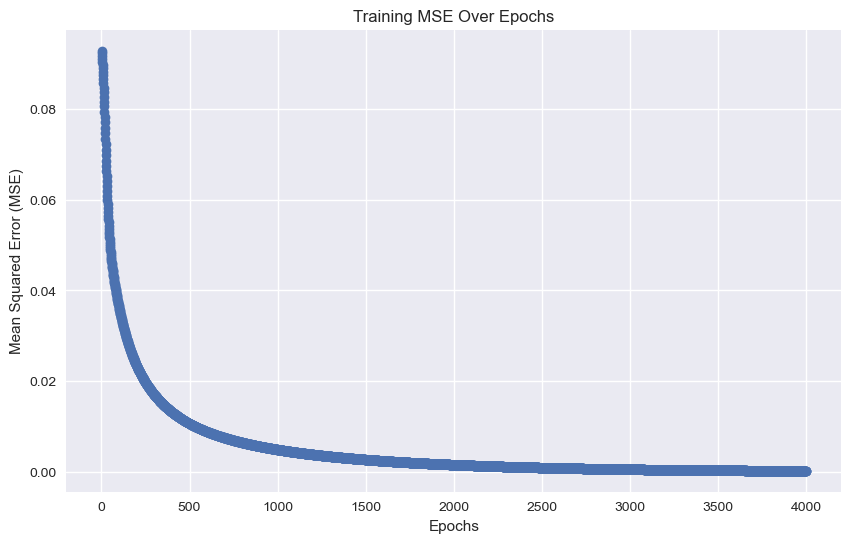

c:\Users\yanch\.conda\envs\cov-env\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\yanch\.conda\envs\cov-env\lib\site-packages\numpy\core\_methods.py:258: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\yanch\.conda\envs\cov-env\lib\site-packages\matplotlib\axes\_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
c:\Users\yanch\.conda\envs\cov-env\lib\site-packages\matplotlib\axes\_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


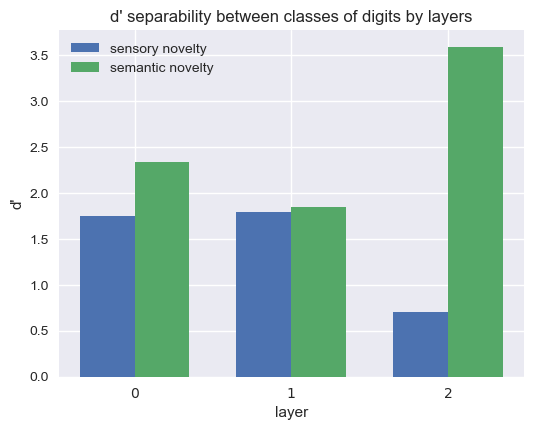

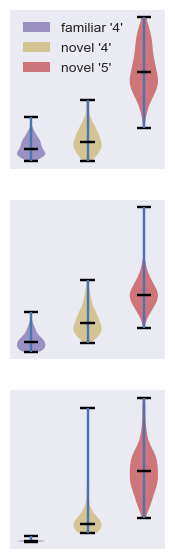

In [5]:
plot_mses(result_path, train_mses)
plot_separability(result_path, separability_12, separability_23)
violin_historgrams(result_path, energy_fam, energy_nov, energy_test_nov)